In [59]:
import torch
from PIL import Image
import torch
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [100]:
# CNN 모델 불러오기
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)

Using cache found in C:\Users\Playdata/.cache\torch\hub\pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Playdata/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


In [124]:
# feature 추출하기
def extract_feature(filepath,image_name) :
    input_image = Image.open(filepath+image_name)
    preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the mode

    if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

    with torch.no_grad():
      output = model(input_batch)

    return torch.nn.functional.softmax(output[0], dim=0)

In [102]:
from os import listdir
from os.path import isfile, join
filepath = 'C:/kjy/pics/frontend/src/assets/img/studio'
files = [f for f in listdir(filepath) if isfile(join(filepath, f))]

In [103]:
# 서버 이미지 불러오기
import time
start = time.time()
filepath = 'C:/kjy/pics/frontend/src/assets/img/studio/'
feature_list = []
for i in range(1000):
    vector = extract_feature(filepath, files[i])
    feature = {
      'name' : files[i],
      'vector' : vector
      }
    feature_list.append(feature)
print(len(feature_list))
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

1000
time : 425.6376848220825


In [117]:
def get_sim_pic(filepath, file):
    target_img = extract_feature(filepath,file)
    sim_list = []
    cos = torch.nn.CosineSimilarity(dim=-1)
    for feature in feature_list:
        sim_degree = cos(target_img,feature['vector'])
        sim = {
          'name' : feature['name'],
          'sim_degree' : float(sim_degree)
        }
        sim_list.append(sim)
    df = pd.DataFrame(sim_list)
    result_list = df.sort_values(by='sim_degree' ,ascending=False)[:5]['name']
    print(df.sort_values(by='sim_degree' ,ascending=False)[:5])
    return result_list

In [105]:
def show_pics(result_list, target_file) :
    print(target_file)
    img =Image.open(filepath+target_file)
    # img.show()
    pix=np.array(img)
    plt.imshow(img)
    plt.show()
    print('-'*30)
    for img_name in result_list:
        print(img_name)
        img =Image.open(filepath+img_name)
        pix=np.array(img)
        plt.imshow(img)
        plt.show()

                                 name  sim_degree
792                   24_5_로코코_경주.jpg    0.996982
996                37_0_티앤북스_경성대점.jpg    0.996931
265  14_0_라이브_스트림_가능한_LIVE24_HALL.jpg    0.996581
800       25_1_삼성동_코엑스_앞_피자펍_공간대여.jpg    0.996524
653                   20_0_플러스레이블.jpg    0.996443
37_5_티앤북스_경성대점.jpg


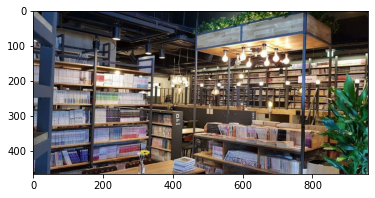

------------------------------
24_5_로코코_경주.jpg


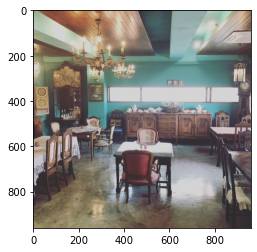

37_0_티앤북스_경성대점.jpg


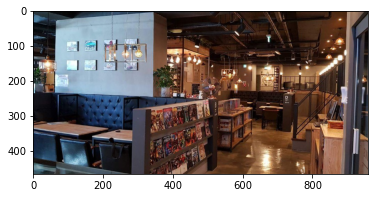

14_0_라이브_스트림_가능한_LIVE24_HALL.jpg


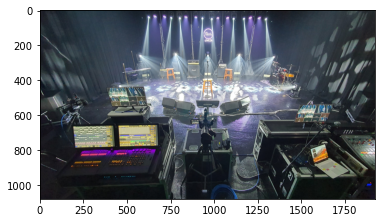

25_1_삼성동_코엑스_앞_피자펍_공간대여.jpg


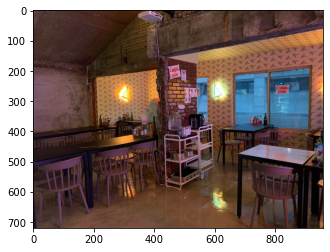

20_0_플러스레이블.jpg


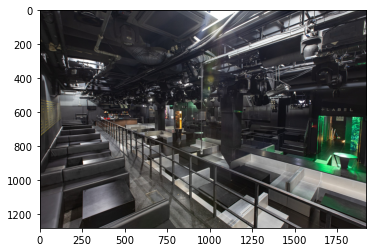

In [121]:
file = files[1001]
result_list = get_sim_pic(filepath, file)
show_pics(result_list, file)

In [123]:
# 화면에서 요청한 이미지 가져와 추출
print(files[1002]) # 사진 지정... 서버 연결 시 삭제
target_img = extract_feature(filepath,files[1002])

38_0_쁠롱드셰프_작은식당(작당).jpg
tensor([[-1.2054e+00, -4.5148e-01, -5.8721e-01, -1.1852e+00, -6.5177e-01,
         -3.2416e-01, -8.8233e-01,  4.4893e-01,  2.0303e-01, -6.5614e-01,
         -8.2490e-01, -9.0893e-01, -4.1439e-01, -8.5961e-01, -8.5908e-01,
         -3.4549e-01, -6.8655e-01, -1.2886e-01, -8.3040e-02, -4.8686e-01,
         -1.1129e+00, -7.5846e-01, -1.2651e+00, -1.8017e-01, -8.4790e-01,
         -6.8403e-01, -8.5401e-01, -6.3572e-01, -6.3001e-01, -5.8843e-01,
         -8.8701e-01, -9.3740e-01, -7.2035e-01, -5.0154e-01, -2.0529e-01,
         -5.4706e-01,  5.3700e-01, -5.7846e-01, -4.3801e-01,  2.8519e-01,
         -6.1368e-01, -6.6258e-01, -6.5838e-01, -2.6169e-01, -2.2664e-01,
         -1.8996e-01, -4.6418e-01, -4.0577e-01, -1.0641e+00, -7.2118e-01,
         -2.4856e-01,  4.2747e-01, -4.1619e-01, -3.9038e-01, -2.8728e-01,
         -9.3919e-01, -5.1431e-01, -1.0881e+00, -3.1455e-01, -1.5762e-01,
          6.0722e-01,  6.8896e-02, -1.2922e-01, -1.6878e-01, -6.6218e-01,
         -2.78

In [111]:
# 유사도 측정
sim_list = []
cos = torch.nn.CosineSimilarity(dim=-1)
for feature in feature_list:
    sim_degree = cos(target_img,feature['vector'])
    sim = {
      'name' : feature['name'],
      'sim_degree' : float(sim_degree)
    }
    sim_list.append(sim)
print(sim_list)

[{'name': '0_0_Large_rooftop_with_panorama_city_view!.jpg', 'sim_degree': 0.9701448082923889}, {'name': '0_0_lofi_스튜디오_(파티룸).jpg', 'sim_degree': 0.9770959615707397}, {'name': '0_0_must_be.jpg', 'sim_degree': 0.9786703586578369}, {'name': '0_0_강남_소규모_사무실_대관합니다..jpg', 'sim_degree': 0.9816679954528809}, {'name': '0_0_낮엔_햇살맛집_밤엔_조명맛집_(을지로_와인바).jpg', 'sim_degree': 0.9777140617370605}, {'name': '0_0_서울문스튜디오_B룸.jpg', 'sim_degree': 0.9793223738670349}, {'name': '0_0_프렌치_미니멀리즘을_실현한_33평_아파트.jpg', 'sim_degree': 0.9786245822906494}, {'name': '0_0_희망나무가족상담센터(심리상담센터).jpg', 'sim_degree': 0.9797440767288208}, {'name': '0_11_Large_rooftop_with_panorama_city_view!.jpg', 'sim_degree': 0.9720844030380249}, {'name': '0_11_lofi_스튜디오_(파티룸).jpg', 'sim_degree': 0.9794503450393677}, {'name': '0_11_서울문스튜디오_B룸.jpg', 'sim_degree': 0.9766941070556641}, {'name': '0_11_프렌치_미니멀리즘을_실현한_33평_아파트.jpg', 'sim_degree': 0.9778726100921631}, {'name': '0_1_Large_rooftop_with_panorama_city_view!.jpg', 'sim_degree': 0.97516816854

In [88]:
df = pd.DataFrame(sim_list)
result_list = df.sort_values(by='sim_degree' ,ascending=False)[:5]['name']
result_list

884                          29_4_라운지물랑.jpg
974                   33_1_동대문_엔틱플라워_카페.jpg
590                    1_1_동대문_엔틱플라워_카페.jpg
149    12_0_80년대_한국_가정집을_개조한_공간_휘(_Hwi).jpg
500               18_3_분당_수내동_앤틱_갤러리하우스.jpg
Name: name, dtype: object

38_0_쁠롱드셰프_작은식당(작당).jpg


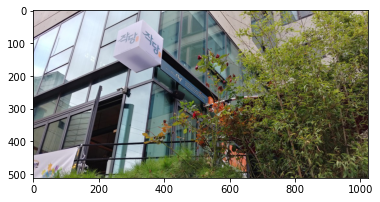

------------------------------
29_4_라운지물랑.jpg


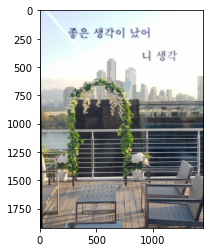

33_1_동대문_엔틱플라워_카페.jpg


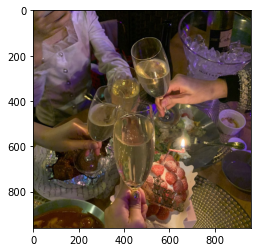

1_1_동대문_엔틱플라워_카페.jpg


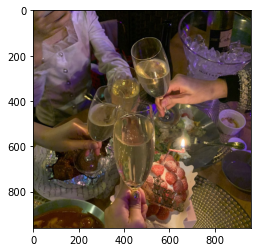

12_0_80년대_한국_가정집을_개조한_공간_휘(_Hwi).jpg


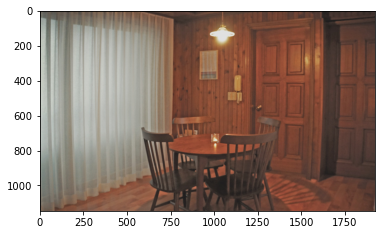

18_3_분당_수내동_앤틱_갤러리하우스.jpg


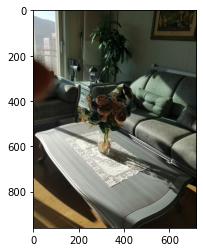

In [89]:
print(files[1002])
img =Image.open(filepath+files[1002])
# img.show()
pix=np.array(img)
plt.imshow(img)
plt.show()
print('-'*30)
for img_name in result_list:
    print(img_name)
    img =Image.open(filepath+img_name)
    pix=np.array(img)
    plt.imshow(img)
    plt.show()

37_5_티앤북스_경성대점.jpg


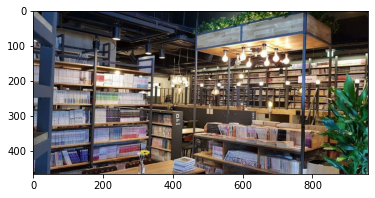

In [75]:

plt.show()

In [13]:
# testset = torchvision.datasets.ImageFolder(root=path[:-9]+'/resources', transform=trans)
path = '../../frontend/src/assets/img'
preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
testset = torchvision.datasets.ImageFolder(path, transform=preprocess)
testloader = torch.utils.data.DataLoader(dataset=testset, shuffle=False)
device = torch.device('cpu')
image_list = []
for image, label in testloader:
    image=image.to(device)
print(len(image))
    

UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='../../frontend/src/assets/img\\studio\\barcel_2.jpg'>